# Read the input dataset :

1. usable_samples_ADNI.json : stores the IID (index) for each row of PRS_feature_matrix.npy
2. PRS_feature_matrix.npy : PR Score for different features
3. Covar_FILE_bigger_dataset : for reading covar such as age, gender
4. Final_Samples.json : contains ID and output for each data

In [1]:
if True:
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn

import pandas as pd
import numpy as np
import json
import random
import math

import os
import time
import sys

import torch as t
from torch import nn
from torch.autograd import Variable
import torch
from torch.utils import data

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"

import shap
from copy import deepcopy

import pickle
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import tpot

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

In [2]:
# !pip install skfeature-chappers
# !pip install mlxtend
# !pip --version
# !pip install imblearn
# !conda install -c conda-forge imbalanced-learn
# conda install -c conda-forge tqdm
# conda install mlxtend

# conda config --add channels conda-forge
# conda install hyperopt

# conda config --add channels conda-forge
# conda config --set channel_priority strict
# conda install auto-sklearn
# conda install -c conda-forge tpot



Show the installed packages with their versions

In [3]:
!conda list

# packages in environment at /home/bayzid/anaconda3:
#
# Name                    Version                   Build  Channel
_anaconda_depends         2020.07                  py37_0  
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                  2_kmp_llvm    conda-forge
absl-py                   1.0.0                    pypi_0    pypi
adjusttext                0.7.3                    pypi_0    pypi
alabaster                 0.7.13             pyhd8ed1ab_0    conda-forge
alignment-c               1.0.0                    pypi_0    pypi
anaconda                  custom                   py37_1  
anaconda-client           1.12.0             pyhd8ed1ab_0    conda-forge
anaconda-navigator        2.1.0            py37h06a4308_0  
anaconda-project          0.11.1             pyhd8ed1ab_0    conda-forge
anyio                     3.7.1              pyhd8ed1ab_0    conda-forge
ar

In [4]:
random_seed = 42 # or any of your favorite number 
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)
random.seed(random_seed)

In [5]:
yrs = 'nores'
progression = ""
SMOTE = False

In [6]:
# Final_Samples_path = './Final Samples/Final_Samples_' + yrs + '.json'
# Final_Samples = json.load(open(Final_Samples_path, 'r')) 
# usable_samples_ADNI = json.load(open('./usable_samples_ADNI.json'))
# PRS_orig_feature_matrix = np.load('./PRS_feature_matrix.npy').astype(np.float32)
# # normalize feature matrix
# PRS_orig_feature_matrix = (PRS_orig_feature_matrix - PRS_orig_feature_matrix.mean(0))/PRS_orig_feature_matrix.std(0)
# # PRS_orig_feature_matrix.shape[1], len(usable_samples_ADNI), usable_samples_ADNI
# num_features=PRS_orig_feature_matrix.shape[1]
# print(len( usable_samples_ADNI ) )
# print(num_features)

In [7]:
# # covar_df = pd.read_csv('./COVAR_FILE_bigger_dataset.txt', ' ') 
# covar_df = pd.read_csv('./COVAR_FILE_bigger_dataset.txt', ' ') 
# print("shape",covar_df.shape)
# print( covar_df[['AGE', 'PTGENDER']].shape, covar_df[['AGE', 'PTGENDER']].dropna().shape ) 
# # PC - Principal Component

# # trying to normalize AGE with having max age of 100
# covar_df['AGE'] = covar_df['AGE'] / 100.0
# print( covar_df.head() )

Covar for ADNI Plink

# Alter parameters :
    1. Number of features
    2. Number of Hidden Layers 
    3. Dimension of Hidden Layers

In [8]:
# num_features = 52
hidden = 4
hidden_dimension = 32

In [9]:
# # take the first num_features column from PRS_feature_matrix
# PRS_feature_matrix = PRS_orig_feature_matrix
# PRS_feature_matrix = PRS_feature_matrix[:, :num_features]
# print(PRS_feature_matrix.shape)

Final Samples has two columns of data :
    1. ID 
    2. output - true / false
    
Get the length of positive and negative samples of test dataset

In [10]:
# # positive samples - output true
# # negative samples - output false
# len_positive_samples = 0
# len_negative_samples = 0
# for x in Final_Samples:
#     if x[1] == 1 :
#         len_positive_samples += 1
#     else :
#         len_negative_samples += 1
        
# print(len(Final_Samples))
# print(len_positive_samples)
# print(len_negative_samples)

# Combining covar data with PRS Feature Matrix

In [11]:
# # cnt = number of missing IDs for which covar data doesn't exist
# cnt = 0
# print("Before adding covar_df columns, shape : ",PRS_feature_matrix.shape)
# # adding ( total columns - 2 ) of covar_df , excluding FID, IID
# FEATURE_MATRIX = np.concatenate([PRS_feature_matrix, np.zeros([PRS_feature_matrix.shape[0], covar_df.shape[1] - 2 ])], 1).astype(np.float32)
# print("Before adding covar_df columns, shape : ",FEATURE_MATRIX.shape)
# for sample in usable_samples_ADNI:
#     # taking from the PCs, skipping the first two columns of IID, FID
#     covar = covar_df[covar_df['IID'] == sample].to_numpy()[:, 2:].astype(np.float32) 
#     # shape[0] = 1 means a row is found in covar for the following sample ID
#     # if not, that means no covar data exists for the sample in usable_samples_ADNI
#     if covar.shape[0] != 1:
# #         print(covar.shape)
#         print(sample)
#         cnt += 1
#         continue
#     # Adding the covar values to the feature matrix
#     FEATURE_MATRIX[usable_samples_ADNI[sample], num_features:] = covar


# print("Count of missing samples for covar data : ", cnt)
# #     FEATURE_MATRIX[usable_samples_ADNI[sample], num_features:] = covar # naeem's modification
# # cnt/FEATURE_MATRIX.shape[0], FEATURE_MATRIX[:2], PRS_feature_matrix[:2]

# Create directory for saving shap figures

In [12]:
# path = "./shap/" + str(num_features)
# if not os.path.exists(path):
#     os.makedirs(path)

# Storing the index with the Age = 0

age is zero for the rows that the covar data was not found

In [13]:
# age_zero = 0
# age_zero_idx = []
# for i in range( len(FEATURE_MATRIX) ):
#     if FEATURE_MATRIX[i, -1] == 0.00:
#         age_zero += 1
#         age_zero_idx.append(i)
        
# print(age_zero)

# Indices of features to consider

In [14]:


# # feature_indices_to_consider = list(range(23))#list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
# # naeem modified
# print(FEATURE_MATRIX.shape[1])
# last_idx = FEATURE_MATRIX.shape[1] - 1
# feature_indices_to_consider = list(range(num_features))  + [last_idx - 1, last_idx] #list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
# # remove_indices = [1, 2, 3]
# # for i in remove_indices:
# #     feature_indices_to_consider.remove(i)

# # feature_indices_to_consider = list(range(23, 36))

# # feature_indices_to_consider = [ 4, 11, 14, 21, 23, 26, 32, 34, 46]

# # feature_indices_to_consider = [ 9, 10, 11, 14, 21, 23, 26, 28, 32, 34, 46]
# # feature_indices_to_consider = [9, 10, 28, 34, 46]

# print(feature_indices_to_consider)
# # feature_indices_to_consider = [1, 2, 3, 11, 14, 21, 23, 26, 32, 45]
# # feature_indices_to_consider = [2, 26, 32, 45]


# Functions & Classes

In [15]:
# save_in_file: saves model accuracy in a text file
#     args : model_name : name of model with layers and dimensions
#            accuracy : accuracy  score
def save_in_file(model_name, accuracy):
    model_file = open("model_details.txt","a")
    model_file.write(model_name + " -> accuracy : " + str(accuracy) + "\n" )
    model_file.close() 

**Modifications**
1. Added relu in the hidden layers and sigmoid in the output layer as activation functions
2. Added dropout in the hidden layers

In [16]:
class simple_model(nn.Module):
    def __init__(self, num_features, hidden_dim= hidden_dimension, drop_probab=.5):
        super(simple_model, self).__init__()
        
        ####
        num_hidden = hidden
        hidden_dim = hidden_dimension
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(num_hidden)])
        self.fc2 = nn.Linear(hidden_dim, 8)
        self.outLayer = nn.Linear(8, 1)
#         self.softmax = nn.Softmax(-1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.num_hidden = num_hidden
        self.drop_probab = drop_probab
        self.dropout = nn.functional.dropout
        ####

    def forward(self, features):
        features = self.fc1(features)
        features = self.dropout(features, p=self.drop_probab)
        for i in range(self.num_hidden):
            features = self.fc_hidden[i](features)
            # added by Mashiat
            features = self.dropout(features, p=self.drop_probab)
            features = self.relu( features )
            ####################
        features = self.fc2(features)
        features = self.dropout(features, p=self.drop_probab)
        logit = self.outLayer(features)
#         print(features.shape, features)
        probab = self.sigmoid(logit)
        return probab
    

In [17]:
# simple_model(num_features=len(feature_indices_to_consider))

# dataSet class 
combines usable_samples_ADNI, Final_Samples, feature_matrix to one dataset with features and labels

In [18]:

# class dataSet(data.Dataset):
#     def __init__(self, Final_Samples, feature_matrix, usable_samples_ADNI, feature_indices_to_consider=feature_indices_to_consider):
#         super(dataSet, self).__init__()  
#         self.data_len = len(Final_Samples)
#         self.usable_samples_ADNI = usable_samples_ADNI
#         self.Final_Samples = Final_Samples
#         self.feature_indices_to_consider = feature_indices_to_consider
#         self.feature_matrix = feature_matrix[:, self.feature_indices_to_consider]
        
#     def __getitem__(self, index):
#         features = torch.from_numpy(self.feature_matrix[self.usable_samples_ADNI[self.Final_Samples[index][0]]]).float()
#         label = torch.tensor([float(self.Final_Samples[index][1])]).float()
#         return features, label
    
#     def update_prs_features(self, mean, std):
#         self.feature_matrix = (self.feature_matrix - mean) / std
        
#     def get_mean_std(self):
#         mean = self.feature_matrix.mean(0)
#         std = self.feature_matrix.std(0)
#         return mean, std
        
#     def __len__(self):
#         return self.data_len

# Converting Pandas Dataframe to Dataset class

overriding the constructor, getitem, len function of the original class

In [19]:
class df_dataSet(data.Dataset):
    def __init__(self, X, y):
        
        self.features = torch.tensor(X.values, dtype=torch.float32)
        self.labels = torch.tensor(y.values, dtype=torch.float32)
        
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
        
        
    def __len__(self):
        return len(self.labels)

In [20]:
# epoch function : runs an epoch of a model
#                 args :
#                         model : neural network model
#                         optimizer :
#                         criterion :
#                         is_training : train - true or test - false
#                         loader : torch dataset
#                 returns :
#                         different accuracy score for the dataset of per epoch
def epoch(model, optimizer, criterion, is_training, loader):
    pred = []
    true = []
    total_loss = 0.
#     print(loader)
    for batch_idx, (features, label) in enumerate(loader):
        features = torch.autograd.Variable(features.to(DEVICE).float())
        label = torch.autograd.Variable(label.to(DEVICE).float())
        label = torch.reshape(label, (label.shape[0], 1))
        probab = model(features)
        if is_training:  
#             print(probab.shape, label.shape)
            loss = criterion(probab, label)
            ## compute gradient and do SGD step 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
#             print(batch_idx, ':', loss) 
        pred += probab.detach().cpu().numpy().tolist()
        true += label.detach().cpu().numpy().tolist()
    
    pred, true, total_loss = np.array(pred).reshape([-1]), np.array(true).reshape([-1]), total_loss
    pred_binary = (pred > .5).astype(float)
    precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
    auroc = roc_auc_score(true, pred)
    p, r, thresholds = precision_recall_curve(true, pred)
    auprc = auc(r, p)
    acc = (pred_binary==true).mean()
    
    return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
#     return None, None, None, None, None, None, acc, total_loss, pred, pred_binary, true
    


**epoch function for LOOCV**

Without precision, recall, ROC, AUC 

In [21]:
# def loocv_epoch(model, optimizer, criterion, is_training, loader):
#     pred = []
#     true = []
#     total_loss = 0.
# #     print(loader)
#     for batch_idx, (features, label) in enumerate(loader):
#         features = torch.autograd.Variable(features.to(DEVICE).float())
#         label = torch.autograd.Variable(label.to(DEVICE).float())
#         label = torch.reshape(label, (label.shape[0], 1))
#         probab = model(features)
#         if is_training:  
# #             print(probab.shape, label.shape)
#             loss = criterion(probab, label)
#             ## compute gradient and do SGD step 
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
# #             print(batch_idx, ':', loss) 
#         pred += probab.detach().cpu().numpy().tolist()
#         true += label.detach().cpu().numpy().tolist()
    
#     pred, true, total_loss = np.array(pred).reshape([-1]), np.array(true).reshape([-1]), total_loss
#     pred_binary = (pred > .5).astype(float)
# #     precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
# #     auroc = roc_auc_score(true, pred)
# #     p, r, thresholds = precision_recall_curve(true, pred)
# #     auprc = auc(r, p)
#     acc = (pred_binary==true).mean()
    
# #     return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
#     return None, None, None, None, None, None, acc, total_loss, pred, pred_binary, true
    

# usable_samples_ADNI 

# SMOTE Analysis to oversample data

https://towardsdatascience.com/smote-synthetic-data-augmentation-for-tabular-data-1ce28090debc#:~:text=SMOTE%20is%20an%20over%2Dsampling,its%20%E2%80%9Ck%E2%80%9D%20nearest%20neighbors.

In [22]:

def smote(x, y):
    # Synthetic Minority Over-samping Technique
    # 
    # sampling_strategy: determines the portion of samples to 
    #                    generate with respect to the majority class
    # k_neighbors : number of neighbors to be considered for each sample
    
    # For this example, only 1% of minoirty samples are considered
    k_neighbors = math.ceil(sum(y) * 0.01)
      
    smote = SMOTE(sampling_strategy=1, 
                  k_neighbors=k_neighbors)
    x, y = smote.fit_resample(x, y)
    
    return x, y
    
def bordersmote(x, y):
    # Borderline-SMOTE
    # 
    # sampling_strategy: determines the portion of samples to 
    #                    generate with respect to the majority class
    # k_neighbors : number of neighbors to be considered for each sample
    # m_neighbors : number of neighbors to consider to determine if a sample is danger
    
    # For this example, only 1% of minoirty samples are considered
    k_neighbors = math.ceil(sum(y) * 0.01)
    m_neighbors = math.ceil(sum(y) * 0.01)
    
    bordersmote = BorderlineSMOTE(sampling_strategy=1, 
                                  k_neighbors=k_neighbors, 
                                  m_neighbors=m_neighbors)
    
    x, y = bordersmote.fit_resample(x, y)
    
    return x, y
    
def adasyn(x, y):
    # Adaptive Synthetic
    # 
    # sampling_strategy: determines the portion of samples to 
    #                    generate with respect to the majority class
    # n_neighbors : number of neighbors to be considered for each sample
    
    # For this example, only 1% of minoirty samples are considered
    n_neighbors = math.ceil(sum(y) * 0.01)
    
    adasyn = ADASYN(sampling_strategy=1,
                   n_neighbors=n_neighbors)
    x, y = adasyn.fit_resample(x, y)

    return x, y

In [23]:
# # dropping last / output column in df
# shuffled_X = shuffled.iloc[: , :-1]
# # taking the output column of df
# shuffled_Y = shuffled.iloc[: , -1]
# print(df.shape)
# df_X_new, df_Y_new = bordersmote(df_X, df_Y)
# print( df_X_new.shape, df_Y_new.shape )

# df = df_X_new
# df['output'] = df_Y_new
# print(df.shape)


In [24]:
# print( df['output'].value_counts() )
# print(df.head())

# # ones = df[df['output'] == 1]
# # zeros = df[df['output'] == 0]
# # min_len = min( len(ones), len(zeros) ) 

# # ones = ones.iloc[:min_len, :]
# # zeros = zeros.iloc[:min_len, :]

# # df = ones.append(zeros, ignore_index=True)
# # print(df.shape)

# Shuffling dataframe

**Dropping alcohol recommended columns**

In [25]:
# # # keep the index same
# # shuffled = df.sample(frac=1)
# # print( shuffled.head() )

# # reset the index
# shuffled = df.sample(frac=1, random_state = 1).reset_index()
# # print(shuffled.columns)
# shuffled = shuffled.drop( ['index'], axis = 1 )


# # #  dropping alcohol recommended columns
# # shuffled = shuffled.drop(['Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year'], axis = 1)
# # shuffled = shuffled.drop(['Non-cancer illness code, self-reported: anxiety/panic attacks', 'Sleeplessness / insomnia', 'Non-cancer illness code, self-reported: type 2 diabetes', "Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia", "Alcohol intake frequency", 'Other meat intake' ], axis = 1)

# print( shuffled.head() )



In [26]:
# shuffled.to_csv('adni_shuffled_balanced_'+yrs+'.csv')

# Select features based on all methods

https://www.digitalocean.com/community/tutorials/python-counter-python-collections-counter

In [27]:
# sorted_dict = {k: v for k, v in sorted(dict_features.items(), key=lambda item: item[1], reverse=True)}
# print(sorted_dict)

In [28]:
# # Output keys to a file
# output_file = "column_importance_ADNI.txt"
# with open(output_file, "w") as f:
#     for key in sorted_dict.keys():
#         f.write(key + "\n")

# print("Sorted keys have been written to", output_file)

In [29]:
# from collections import Counter
# # print(selected_features)
# c = Counter( selected_features )
# # print( c )
# # print( c.most_common(20) )
# most_common = c.most_common(15)
# print( most_common )
# selected_col = list( list(zip(*most_common))[0] )
# print(selected_col)

# Drop extra features from Shuffled Dataframe

# Literature Review select features

Features related to : 
**Alcohol Consumption,
Hearing Problem,
Smoking / Cigarettes,
Cholesterol,
Blood Pressure,
Meat,
Depression,
Insomnia /  Sleep Schedule,
Education,
Hypertension,
Physical Inactivity,
Brain Injury,
Father / Mother,
Obesity,
Diabetes,
Age**


'Non-cancer illness code, self-reported: type 2 diabetes'
'Total cholesterol', 'HDL cholesterol', 'LDL cholesterol'
'Cigarettes per Day', 'systolic blood pressure', 'diastolic blood pressure'
'Hearing difficulty/problems: Yes', 'Non-cancer illness code, self-reported: depression’
'Hearing difficulty/problems with background noise'
'Sleeplessness / insomnia', 'Sleep duration', 'Age completed full time education'
'Types of physical activity in last 4 weeks: Strenuous sports', 'Other meat intake', 'Loneliness, isolation', "Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia", 'Mood swings'
'Non-cancer illness code, self-reported: hypertension'
'Diagnoses - secondary ICD10: I10 Essential (primary) hypertension'
'Non-cancer illness code, self-reported: head injury', 'Alcohol intake frequency', 'Diagnoses - secondary ICD10: E66.9 Obesity, unspecified’


In [30]:
# # selected_col += ['output']
# selected_col = list( shuffled.columns.values )
# # selected_col.remove("Parkinson's disease")
# print(selected_col)
# # selected_col.remove('age')
# # selected_col.remove('gender')

# Read dataset and column priorities

In [31]:
shuffled = pd.read_csv('adni_shuffled_balanced_' + yrs + '.csv')


# Read from the output file and store keys in a list
input_file = "column_importance_ADNI.txt"
if progression != "":
    shuffled = pd.read_csv('adni_shuffled_balanced_' + yrs + '_' + progression + '.csv')
    input_file = "column_importance_ADNI" + progression + ".txt"
col_imp = []

with open(input_file, "r") as f:
    for line in f:
        key = line.strip()  # Remove newline character
        col_imp.append(key)

print("Keys read from the file:", col_imp)

Keys read from the file: ["Alzheimer's disease", 'Age', 'Serious Illness/Injury', 'Brain Surgery', "Parkinson's", 'Hypothyroidism', 'Sports Club/Gym', "Father's Alzheimer's", 'Recommendation of alcohol consumption - Yes, Not Last Year', 'Loneliness', 'BMI', 'Financial Difficulties', 'Age completed full time education', 'Hearing Difficulty - Yes', 'Obesity', 'Depression', 'Non-Oily Fish Intake', 'Systolic blood pressure', 'Marital Separation/Divorce', 'Total Cholesterol', 'Loss of Interest', 'Processed Meat Intake', 'Cigarettes per Day', 'Light Physical Exercise', 'Particulate Matter Air Pollution', 'ADHD', 'Hyperthyroidism', 'No recommendation of alcohol consumption', 'Recommendation of alcohol consumption', 'Pub/Social Club', 'Hypertension 2', 'Anxiety Disorder', 'Anxiety/Panic Attacks', 'Insomnia', 'Hearing Difficulty', "Mother's Alzheimer's", 'Microalbumin in Urine', 'HDL Cholesterol', 'Diastolic blood pressure', 'Head Injury', 'Type 2 Diabetes', 'Other Meat Intake', 'LDL Cholestero

# Selected Column Number

In [32]:
f = open("ADNI_feature_count.txt", "r")
if progression != "":
    f = open("ADNI_feature_count_" + progression + '.txt', "r")
count = f.read()
count = 9
print( int(count) )
cols_to_take = int(count)
selected_col = col_imp[:cols_to_take]
# selected_col.append( 'output' )
print(selected_col)

9
["Alzheimer's disease", 'Age', 'Serious Illness/Injury', 'Brain Surgery', "Parkinson's", 'Hypothyroidism', 'Sports Club/Gym', "Father's Alzheimer's", 'Recommendation of alcohol consumption - Yes, Not Last Year']


In [40]:
# selected_col = shuffled.columns

# Add selected columns of ROSMAP

In [41]:
# # Read from the output file and store keys in a list
# input_file = "../ROSMAP analysis/column_importance_ROSMAP.txt"
# if progression != "":
#     input_file = "../ROSMAP analysis/column_importance_ROSMAP" + progression + ".txt"
# col_imp = []

# with open(input_file, "r") as f:
#     for line in f:
#         key = line.strip()  # Remove newline character
#         col_imp.append(key)

# print("Keys read from the file:", col_imp)

In [42]:
# f = open("../ROSMAP analysis/rosmap_feat_count.txt", "r")
# if progression != "":
#     f = open("../ROSMAP analysis/rosmap_feat_count_" + progression + ".txt", "r")
# count = f.read()
# print( int(count) )
# cols_to_take = int(count)
# selected_col_ros = col_imp[:cols_to_take]
# # selected_col.append( 'output' )
# print(selected_col_ros)

In [43]:
# selected_col = selected_col + selected_col_ros
# selected_col = list(set( selected_col ) )
# print( selected_col )

# Add AD

In [44]:
# if 'Alzheimer\'s Disease' not in selected_col:
#     print("Not exists")
#     selected_col.append('Alzheimer\'s disease' )

selected_col.append( 'output' )
print(selected_col)

TypeError: all inputs must be Index

# Longitudinal Analysis 

In [45]:
selected_col = shuffled.columns

In [46]:
# cols_to_take = len(col_imp)
# selected_col = col_imp[:cols_to_take]
# selected_col.append( 'output' )
# print(selected_col)

In [47]:
shuffled = shuffled[selected_col]

# file = open('ROSMAP analysis/columns.txt','w')
# for item in selected_col:
#     file.write(item+"\n")
# file.close()

print( shuffled.shape )
print( shuffled.head() )

# dropping last / output column in df
shuffled_X = shuffled.iloc[: , :-1]
shuffled_Y =  shuffled.iloc[: , -1]

(1152, 57)
   Unnamed: 0  Type 2 Diabetes  No recommendation of alcohol consumption  \
0           0        -1.907915                                 -0.063395   
1           1         1.289058                                 -0.502094   
2           2        -0.381645                                  0.041821   
3           3         0.114929                                  0.221493   
4           4         0.503239                                 -0.063222   

   Recommendation of alcohol consumption - Yes, Not Last Year  \
0                                           0.233013            
1                                           0.518958            
2                                          -1.287524            
3                                          -0.320702            
4                                          -0.696554            

   Recommendation of alcohol consumption  Total Cholesterol  HDL Cholesterol  \
0                              -0.189565          -1.677074  

# LOOCV

**Random Forest Classifier with LOOCV**

**Neural Network Model with LOOCV**

Epoch number is reduced to 250

In [48]:
def printScores(avg_acc,avg_prec,avg_rec,avg_fsc,avg_roc,avg_prc):
    print("accuracy:",avg_acc)
    print("precision:",avg_prec)
    print("recall:",avg_rec)
    print("fscore:",avg_fsc)
    print("auroc:",avg_roc)
    print("auprc:",avg_prc)

In [49]:
import csv
import os

# CSV file path
def write_out_to_csv(datatype, model, years, acc, prec, rec, auprc, auroc, fscore):
    csv_file_path = "scores.csv"

    # Check if the CSV file already exists
    if not os.path.exists(csv_file_path):
        # Create a new CSV file and write header
        with open(csv_file_path, "w", newline="") as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(["Datatype", "Model", "Year", "Size", "Features","Average Accuracy", "Average Precision", "Average Recall", "Average F-Score", "Average ROC AUC", "Average PR AUC"])

    # Append data to the CSV file
    with open(csv_file_path, "a", newline="") as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow([datatype, model, years, shuffled.shape[0], shuffled_X.shape[1], acc, prec, rec, fscore, auroc, auprc])

    print("Average scores have been appended to the CSV file.")

# Model training

https://www.analyticsvidhya.com/blog/2021/09/a-comprehensive-guide-on-neural-networks-performance-optimization/

In [52]:
# tensor_X = torch.tensor(shuffled_X.values, dtype=torch.float32).to(DEVICE)
# print( tensor_X[0].shape )

GENERATE_SHAP = True
total_epochs = 500 #250(ideal)
num_features = shuffled_X.shape[1]
# random_integers = [2, 6, 108, 90, 5]
random_seed = random_seed#, 92, 0, 87, 73, 82, 54]

total_folds = 10#[37*2]

avg_val_acc = []

shap_values_list = []
# for num_features in num_features_list:
print(f'NF:{num_features}')
global_best_acc_val = 0.
precision_avg = 0
recall_avg = 0
auprc_avg = 0
auroc_avg = 0
fscore_avg = 0
# for total_folds in folds_list:
print(f'\n#F{total_folds}')
# for random_seed in random_integers:
accuracies = []
accuracies_val = []
temp_shap_values = np.zeros(shuffled_X.shape)

kf = KFold(n_splits = total_folds, random_state=None)
acc_score = []

for train_index , test_index in kf.split(shuffled):
    print("Split :")
    X_train , X_test = shuffled_X.iloc[train_index,:], shuffled_X.iloc[test_index,:]
    y_train , y_test = shuffled_Y[train_index] , shuffled_Y[test_index]
    
    if SMOTE == True:

        X_train, y_train = bordersmote( X_train, y_train )
        print("train size: ", X_train.shape, y_train.shape)
        print("test size: ", X_test.shape, y_test.shape)

    train_dataset = df_dataSet( X_train, y_train )
    valid_dataset = df_dataSet( X_test, y_test )

    train_batch_size = train_dataset.__len__()
    val_batch_size = valid_dataset.__len__()

#                 print( train_batch_size, val_batch_size )

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = False, num_workers = 0)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = val_batch_size, shuffle = False, num_workers = 0)

    model = simple_model(num_features = shuffled_X.shape[1], hidden_dim = hidden_dimension)
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCEWithLogitsLoss() 
    best_acc_val = 0.
    model_best = None

    for epoch_num in range(total_epochs):
#         print(epoch_num)
        model.train()
#                     model.drop_probab=.8
#                     print("model trained")
        precision, recall, fscore, support, auroc, auprc, acc_train, total_loss, pred, pred_binary, true = epoch(model=model, optimizer=optimizer, 
                                                                                 criterion=criterion, is_training=True, 
                                                                               loader=train_loader)
#                     print("model validated")
        model.eval()
#                     model.drop_probab=.0
        precision, recall, fscore, support, auroc, auprc, acc_val, total_loss, pred, pred_binary, true = epoch(model=model, 
                                                                                 optimizer=optimizer, 
                                                                                 criterion=criterion, is_training=False, 
                                                                                loader=valid_loader)
#                     print("model kahini done")
        if acc_val > best_acc_val:
            best_acc_val = acc_val
            if acc_val > global_best_acc_val:
                global_best_acc_val = acc_val
#                         print('global updated!')
            torch.save(model.state_dict(), 'PRS_model.pt')
#                     print(f'#F:{total_folds}| seed:{random_seed}, fold:{fold_num}, epoch:{epoch_num} -> local:{best_acc_val}, global:{global_best_acc_val}')  
#                     if epoch_num + 1 == total_epochs:
#     #                     print(f'LAST_Epoch:{epoch_num}, train_acc:{acc_train}, val_acc:{acc_val}, local_best:{best_acc_val}, global_best:{global_best_acc_val}')
#                         pass
    model_best = simple_model(num_features= shuffled_X.shape[1], hidden_dim = hidden_dimension, drop_probab=.0)
    model_best.load_state_dict(torch.load('PRS_model.pt'))
    model_best = model_best.to(DEVICE)
    model_best.eval()
    precision, recall, fscore, support, auroc, auprc, acc_test, total_loss, pred, pred_binary, true = epoch(model=model_best, 
                                                                             optimizer=optimizer, 
                                                                             criterion=criterion, is_training=False, 
                                                                             loader=valid_loader)
    accuracies += [acc_test]
    accuracies_val += [best_acc_val]
#                 print("precision : ", precision, " ; recall : ", recall)
    precision_avg += precision
    recall_avg += recall
    auprc_avg += auprc
    auroc_avg += auroc
    fscore_avg += fscore

#                 print(precision, recall, fscore, support, auroc, auprc, acc_test, total_loss)
#                 print("pred")
#                 print(pred)
#                 print("pred binary")
#                 print(type(pred_binary))
#                 print(pred_binary)

    print(total_folds, ':')
#     if GENERATE_SHAP:
#         explainer = shap.GradientExplainer(model_best.to(DEVICE), tensor_X,
#                                            batch_size=shuffled_X.shape[0]) #https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html
# #                     print("usable features : ", usable_features.shape[0])
# #                     print(usable_features.shape)
# #                     print(usable_features)
#         shap_values = explainer.shap_values(tensor_X, nsamples=500)
# #                     print("shap values shape : ", shap_values.shape)
# #                     print("Shap values : ", shap_values)
# #                     print("shap values of 0 index", shap_values[0, :])

#         temp_shap_values += shap_values 
# if GENERATE_SHAP:
#     temp_shap_values /= total_folds
#     shap_values_list += [temp_shap_values] 
print(f'random_seed:{random_seed}:', np.mean(accuracies), np.std(accuracies), 
      np.mean(accuracies_val), np.std(accuracies_val), 'train acc:', acc_train)
avg_val_acc += [np.mean(accuracies_val)]
print("accuraacies of validation: ", accuracies_val)
print(f'global_best_acc_val:{global_best_acc_val}')
precision_avg = precision_avg * 1.0 / total_folds
recall_avg = recall_avg * 1.0 / total_folds
auprc_avg = auprc_avg * 1.0 / total_folds
auroc_avg = auroc_avg * 1.0 / total_folds
fscore_avg = fscore_avg * 1.0 / total_folds
print( "precision avg : ", precision_avg )
print( "recall avg : ", recall_avg )
print( "AUPRC avg : ", auprc_avg )
print( "AUROC avg : ", auroc_avg )
print( "FScore avg : ", fscore_avg )
avg_val_acc = np.array(avg_val_acc)
printScores(avg_val_acc,precision_avg,recall_avg,fscore_avg,auroc_avg,auprc_avg)
if progression == "":
    if SMOTE == False:
        write_out_to_csv("ADNI", "NN", yrs, avg_val_acc, precision_avg,recall_avg,fscore_avg,auroc_avg,auprc_avg)
    else:
        write_out_to_csv("ADNI_SMOTE", "NN", yrs, avg_val_acc, precision_avg,recall_avg,fscore_avg,auroc_avg,auprc_avg)
    
 




NF:56

#F10
Split :
10 :
Split :
10 :
Split :
10 :
Split :
10 :
Split :
10 :
Split :
10 :
Split :
10 :
Split :
10 :
Split :
10 :
Split :
10 :
random_seed:42: 0.5252023988005996 0.048721367590587886 0.5833133433283357 0.03808745473418144 train acc: 0.5438765670202508
accuraacies of validation:  [0.603448275862069, 0.5862068965517241, 0.5739130434782609, 0.6695652173913044, 0.5217391304347826, 0.5739130434782609, 0.5565217391304348, 0.5565217391304348, 0.5739130434782609, 0.6173913043478261]
global_best_acc_val:0.6695652173913044
precision avg :  0.23861627960877022
recall avg :  0.18465248883736765
AUPRC avg :  0.5261373139371914
AUROC avg :  0.5183341354624459
FScore avg :  0.19150241687114844
accuracy: [0.58331334]
precision: 0.23861627960877022
recall: 0.18465248883736765
fscore: 0.19150241687114844
auroc: 0.5183341354624459
auprc: 0.5261373139371914
Average scores have been appended to the CSV file.


In [53]:
# # save model accuracy in model_details.txt
# save_in_file("Neural Network with " + str(hidden)  + " layers_4yrs_" + str(len(feature_indices_to_consider)), global_best_acc_val)
# # save_in_file("Neural Network with " + str(hidden) + " layers", global_best_acc_val)

In [54]:
# usable_features = usable_features.cpu().detach().numpy().astype(np.float64)

# Shap Analysis

https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

In [55]:
# # print( shap_values_list )
# # write shap_values_list to pkl file
# pickle.dump(shap_values_list, open('shap_values_list.pkl', 'wb'))
# shap_values = np.mean(shap_values_list, axis=0)
# print( shap_values.shape )
# # print(shap_values)

# Force plot :


The shap.force_plot() takes three values: 

(i) the base value (explainerModel.expected_value[0]),

(ii) the SHAP values (shap_values_Model[j][0]) and 

(iii) the matrix of feature values (S.iloc[[j]]). The base value or the expected value is the average of the model output over the training data X_train. It is the base value used in the following plot.

https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195

the bold 0.80 is the model’s score for this observation. Higher scores lead the model to predict 1 and lower scores lead the model to predict 0. The features that were important to making the prediction for this observation are shown in red and blue, with red representing features that pushed the model score higher, and blue representing features that pushed the score lower. Features that had more of an impact on the score are located closer to the dividing boundary between red and blue, and the size of that impact is represented by the size of the bar.

In [56]:
# # print( shap_values_list )

# # print the JS visualization code to the notebook
shap.initjs()

# # print(shap_values[0, :])
# # print(usable_features[0, :])
# # shap.summary_plot(shap_values[:, :], usable_features[:, :])

# # shap.force_plot(.5, shap_values[0,:], usable_features[0, :], link = "logit", matplotlib = True)  

# # using pandas dataframe
# shap.force_plot(.5, shap_values[0,:], shuffled_X.iloc[0, :], link = "logit", matplotlib = True  )  

In [57]:
# # shap.force_plot(.5, shap_values[:,:], usable_features[:, :], link="logit")

# # using pandas dataframe
# print(shap_values.shape)
# print(shuffled_X.shape)
# shap.force_plot(.5, shap_values[:,:], shuffled_X.iloc[:, :], link="logit")

# Summary Plot
This plot is made of all the dots in the train data. It delivers the following information:

Feature importance: Variables are ranked in descending order.

Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.

Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

Correlation: A high level of the “alcohol” content has a high and positive impact on the quality rating. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “volatile acidity” is negatively correlated with the target variable.

In [58]:
# sorted(list(zip(list(range(23)), abs(shap_values).mean(0))), key=lambda x:x[1], reverse=True)

In [59]:
# path = "./shap/" + str(num_features)
# if not os.path.exists(path):
#     os.makedirs(path)
    
# # for trait in traits:
# #     print(trait)
# # https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# # usable_features_std = (usable_features - usable_features.mean(0))/usable_features.std(0)
# # shap.summary_plot(shap_values, features=usable_features, feature_names=traits, plot_type='dot', max_display=len(traits), show = False)
# # plt.savefig('shap/' + str(num_features) + '/summary_plot_hidden_'+ str(hidden) + '_dim_' + str(hidden_dimension) + '.pdf',  bbox_inches='tight')
# # shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(23)), plot_type='dot', max_display=len(traits))

# shap.summary_plot(shap_values, features = shuffled_X, feature_names = shuffled_X.columns, plot_type='dot', max_display=len(traits), show = False)


In [60]:
# # https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# # shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(23)), plot_type='bar', max_display=len(traits), show=False)
# # plt.savefig('shap/summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')
# # naeem modified
# # shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(num_features)), plot_type='bar', max_display=len(traits), show=False)
# # shap.summary_plot(shap_values, features=usable_features, feature_names = traits, plot_type='bar', max_display=len(traits), show=False)
# # plt.savefig('shap/' + str(num_features) + 'summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')

# shap.summary_plot(shap_values, features = shuffled_X, feature_names = shuffled_X.columns, plot_type='bar', max_display=len(traits), show=False)
# plt.savefig('shap/' + str(num_features) + 'summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')

In [61]:
help(shap.force_plot)


Help on function force in module shap.plots._force:

force(base_value, shap_values=None, features=None, feature_names=None, out_names=None, link='identity', plot_cmap='RdBu', matplotlib=False, show=True, figsize=(20, 3), ordering_keys=None, ordering_keys_time_format=None, text_rotation=0, contribution_threshold=0.05)
    Visualize the given SHAP values with an additive force layout.
    
    Parameters
    ----------
    base_value : float
        This is the reference value that the feature contributions start from. For SHAP values it should
        be the value of explainer.expected_value.
    
    shap_values : numpy.array
        Matrix of SHAP values (# features) or (# samples x # features). If this is a 1D array then a single
        force plot will be drawn, if it is a 2D array then a stacked force plot will be drawn.
    
    features : numpy.array
        Matrix of feature values (# features) or (# samples x # features). This provides the values of all the
        features, an

# precision, recall, fscore, auroc, auprc,accuracy score

In [62]:
def GetScores(true,pred_binary,pred):
    print(true.shape,pred_binary.shape,pred.shape)
    precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
    auroc = roc_auc_score(true, pred)
    p, r, thresholds = precision_recall_curve(true, pred)
    auprc = auc(r, p)
    acc = (pred_binary==true).mean()


#     print("precision",precision[1],"recall", recall[1], "fscore",fscore[1], "auroc", auroc,"auprc", auprc,"accuracy" ,acc)
    return acc, precision[1], recall[1], fscore, auroc, auprc


In [63]:
# AutoML

In [64]:
# # example of tpot for the sonar classification dataset
# from pandas import read_csv
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import RepeatedStratifiedKFold
# from tpot import TPOTClassifier

# # define model evaluation
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define search
# model = TPOTClassifier(generations=5, population_size=50, cv=cv, scoring='accuracy', verbosity=2, random_state=1, n_jobs=-1)
# # perform the search
# model.fit(shuffled_X, shuffled_Y)
# # export the best model
# model.export('tpot_sonar_best_model.py')

# GradientBoosting

In [65]:
print(SMOTE)

False


In [66]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
# tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
# features = tpot_data.drop('target', axis=1)
# training_features, testing_features, training_target, testing_target = \
#             train_test_split(shuffled_X, shuffled_Y, random_state=1)
# print("training_features",X_train.shape)
# print("testing_features",X_test.shape)
print( shuffled_X.shape)

# Average CV score on the training set was: 0.6719885773624091
exported_pipeline = GradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_features=1, min_samples_leaf=7, min_samples_split=6, n_estimators=100, subsample=0.45)
# Fix random state in exported estimator
accuracies=[]
precisions=[]
recalls=[]
fscores=[]
aurocs=[]
auprcs=[]
SHAP_values_per_fold = [] #-#-#

if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', random_seed)

for train_index , test_index in kf.split(shuffled):
#     print("test index ", test_index)
    X_train , X_test = shuffled_X.iloc[train_index,:], shuffled_X.iloc[test_index,:]
    y_train , y_test = shuffled_Y[train_index] , shuffled_Y[test_index]
    
       
    if SMOTE == True:

        X_train, y_train = bordersmote( X_train, y_train )
        print("train size: ", X_train.shape, y_train.shape)
        print("test size: ", X_test.shape, y_test.shape)

    exported_pipeline.fit(X_train, y_train)
    y_pred = exported_pipeline.predict(X_test)

    true=y_test
    pred_binary=y_pred
    pred=exported_pipeline.predict_proba(X_test).T
    pred=pred[1]
    acc,precision, recall,fscore, auroc, auprc=GetScores(true,pred_binary,pred)
    
    # Use SHAP to explain predictions
    explainer = shap.TreeExplainer(exported_pipeline)
    shap_values = explainer.shap_values(X_test)
    for SHAPs in shap_values:
        SHAP_values_per_fold.append(SHAPs) #-#-#

    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    aurocs.append(auroc)
    auprcs.append(auprc)
avg_acc=np.mean(accuracies)
avg_prec=np.mean(precisions)
avg_rec=np.mean(recalls)
avg_fsc=np.mean(fscores)
avg_roc=np.mean(aurocs)
avg_prc=np.mean(auprcs)

printScores(avg_acc,avg_prec,avg_rec,avg_fsc,avg_roc,avg_prc)

(1152, 56)
(116,) (116,) (116,)
(116,) (116,) (116,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
accuracy: 0.6319265367316341
precision: 0.6463529762886517
recall: 0.5863125426760696
fscore: 0.6294994871598905
auroc: 0.6695943491883023
auprc: 0.642371943851702


In [67]:
if progression  == "":
    if SMOTE == False:
        write_out_to_csv("ADNI", "XGBoost", yrs, avg_acc, avg_prec, avg_rec, avg_fsc, avg_roc, avg_prc)
    else:
        write_out_to_csv("ADNI_SMOTE", "XGBoost", yrs, avg_acc, avg_prec, avg_rec, avg_fsc, avg_roc, avg_prc)
else:
    write_out_to_csv("ADNI_" + progression, "XGBoost", yrs, avg_acc, avg_prec, avg_rec, avg_fsc, avg_roc, avg_prc)
    

Average scores have been appended to the CSV file.


(1152, 56)


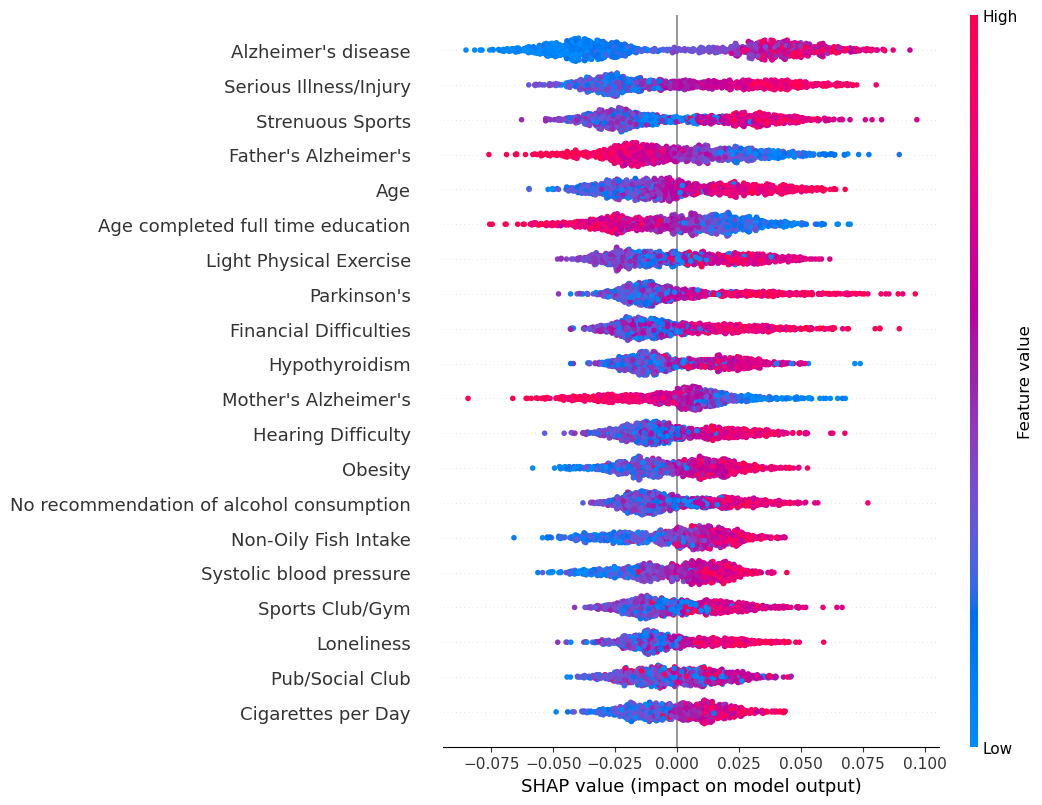

In [68]:
print( np.array(SHAP_values_per_fold).shape )
shap.summary_plot(np.array(SHAP_values_per_fold), shuffled_X,show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.show()


(1152, 56)


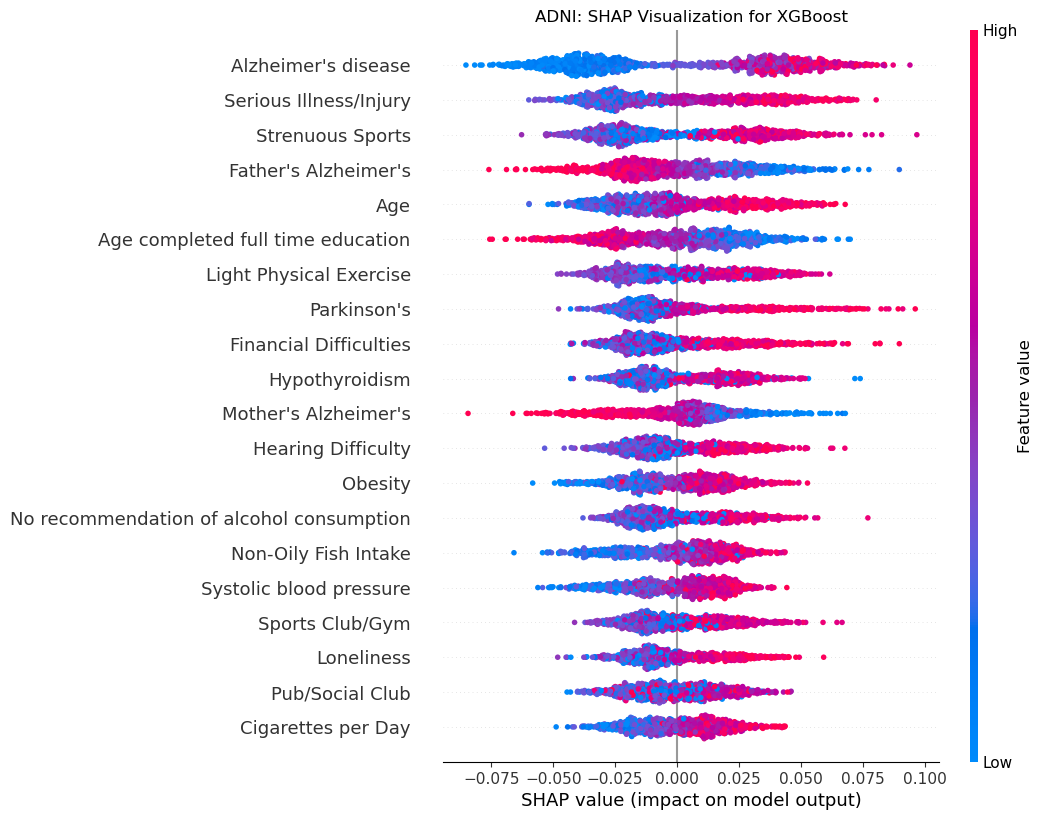

<Figure size 640x480 with 0 Axes>

In [69]:
print( np.array(SHAP_values_per_fold).shape )
shap.summary_plot(np.array(SHAP_values_per_fold), shuffled_X,  show=False)
plt.title("ADNI: SHAP Visualization for XGBoost", fontsize = 12)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.show()
plt.savefig("adni_shap.png",dpi=600)

In [125]:
# print(shap_values)
# # print( shuffled_X.shape )
# shap.summary_plot(shap_values, shuffled_X)

# SVM

In [126]:
# X_train, X_test, y_train, y_test = train_test_split(shuffled_X, shuffled_Y, test_size=0.25, random_state=0)

# Preprocess the data
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# Create an SVM object
from sklearn.svm import SVC
classifier = SVC(kernel='linear', random_state=random_seed, probability=True)


accuracies=[]
precisions=[]
recalls=[]
fscores=[]
aurocs=[]
auprcs=[]
for train_index , test_index in kf.split(shuffled):
    X_train , X_test = shuffled_X.iloc[train_index,:], shuffled_X.iloc[test_index,:]
    y_train , y_test = shuffled_Y[train_index] , shuffled_Y[test_index]
    
    if SMOTE == True:

        X_train, y_train = bordersmote( X_train, y_train )
        print("train size: ", X_train.shape, y_train.shape)
        print("test size: ", X_test.shape, y_test.shape)
   
    # Train the model
    classifier.fit(X_train, y_train)

    # Evaluate the model
    y_pred = classifier.predict(X_test)
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
#     print(cm)

    true=y_test
    pred_binary=y_pred
    pred=classifier.predict_proba(X_test).T
    pred=pred[1]
    acc,precision, recall,fscore, auroc, auprc=GetScores(true,pred_binary,pred)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    aurocs.append(auroc)
    auprcs.append(auprc)
avg_acc=np.mean(accuracies)
avg_prec=np.mean(precisions)
avg_rec=np.mean(recalls)
avg_fsc=np.mean(fscores)
avg_roc=np.mean(aurocs)
avg_prc=np.mean(auprcs)
printScores(avg_acc,avg_prec,avg_rec,avg_fsc,avg_roc,avg_prc)
if progression == "":
    if SMOTE == False:
        write_out_to_csv("ADNI", "SVM", yrs, avg_acc, avg_prec, avg_rec, avg_fsc, avg_roc, avg_prc)
    else:
        write_out_to_csv("ADNI_SMOTE", "SVM", yrs, avg_acc, avg_prec, avg_rec, avg_fsc, avg_roc, avg_prc)
        


(47,) (47,) (47,)
(47,) (47,) (47,)
(47,) (47,) (47,)
(47,) (47,) (47,)
(46,) (46,) (46,)
(46,) (46,) (46,)
(46,) (46,) (46,)
(46,) (46,) (46,)
(46,) (46,) (46,)
(46,) (46,) (46,)
accuracy: 0.7279833487511563
precision: 0.729474539900248
recall: 0.720255246702615
fscore: 0.7241975827946335
auroc: 0.7657049577149692
auprc: 0.7563429584375385
Average scores have been appended to the CSV file.


In [127]:

# shap.summary_plot(shap_values, training_features, plot_type="bar")

In [128]:
# SVM

# Random Forest Classifier

In [129]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=random_seed)
accuracies=[]
precisions=[]
recalls=[]
fscores=[]
aurocs=[]
auprcs=[]
for train_index , test_index in kf.split(shuffled):
    X_train , X_test = shuffled_X.iloc[train_index,:], shuffled_X.iloc[test_index,:]
    y_train , y_test = shuffled_Y[train_index] , shuffled_Y[test_index]
    
    if SMOTE == True:

        X_train, y_train = bordersmote( X_train, y_train )
        print("train size: ", X_train.shape, y_train.shape)
        print("test size: ", X_test.shape, y_test.shape)
   
    rfc.fit(X_train, y_train)
    y_pred_bin = rfc.predict(X_test)
    y_pred_frac= rfc.predict_proba(X_test).T[1]
    acc,precision, recall,fscore, auroc, auprc=GetScores(y_test,y_pred_bin,y_pred_frac)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    aurocs.append(auroc)
    auprcs.append(auprc)
avg_acc=np.mean(accuracies)
avg_prec=np.mean(precisions)
avg_rec=np.mean(recalls)
avg_fsc=np.mean(fscores)
avg_roc=np.mean(aurocs)
avg_prc=np.mean(auprcs)
printScores(avg_acc,avg_prec,avg_rec,avg_fsc,avg_roc,avg_prc)
if progression == "":
    if SMOTE == False:
        write_out_to_csv("ADNI", "RF", yrs, avg_acc, avg_prec, avg_rec, avg_fsc, avg_roc, avg_prc)
    else:
        write_out_to_csv("ADNI_SMOTE", "RF", yrs, avg_acc, avg_prec, avg_rec, avg_fsc, avg_roc, avg_prc)
        

(47,) (47,) (47,)
(47,) (47,) (47,)
(47,) (47,) (47,)
(47,) (47,) (47,)
(46,) (46,) (46,)
(46,) (46,) (46,)
(46,) (46,) (46,)
(46,) (46,) (46,)
(46,) (46,) (46,)
(46,) (46,) (46,)
accuracy: 0.7364939870490287
precision: 0.75729957304328
recall: 0.6985703526493
fscore: 0.7329264249475803
auroc: 0.7673341099425195
auprc: 0.7779990281661042
Average scores have been appended to the CSV file.
